In [430]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error as mse, precision_score as precision, accuracy_score as accuracy, recall_score as recall

plt.style.use('ggplot')

%matplotlib inline

In [484]:
data = pd.read_csv('../data/OnlineNewsPopularity.csv')

In [504]:
data.describe()[' shares']

count     39644.000000
mean       3395.380184
std       11626.950749
min           1.000000
25%         946.000000
50%        1400.000000
75%        2800.000000
max      843300.000000
Name:  shares, dtype: float64

In [509]:
58 / len(data)

0.0014630208858843708

In [485]:
data.drop(['url',' timedelta'], axis=1, inplace=True)

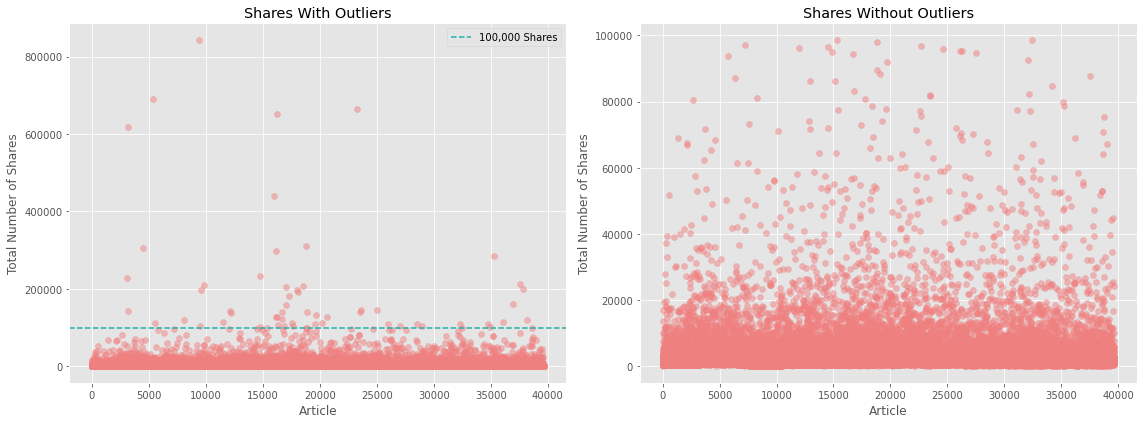

In [514]:
fig, axs  = plt.subplots(1, 2, figsize=(16,6))
axs = axs.flatten()
axs[0].scatter(data.index, data[' shares'], color = 'lightcoral', alpha = .5)
axs[0].axhline(100000, linestyle='--', color = 'lightseagreen', label = '100,000 Shares')
axs[0].set_title('Shares With Outliers')
axs[0].set_ylabel('Total Number of Shares')
axs[0].set_xlabel('Article')
axs[0].legend()

axs[1].scatter(df.index, df[' shares'], color = 'lightcoral', alpha = .5)
axs[1].set_title('Shares Without Outliers')
axs[1].set_ylabel('Total Number of Shares')
axs[1].set_xlabel('Article')

fig.tight_layout()

# plt.savefig('../img/outliers.png')

In [486]:
#dropping the 58 outliers that are beyond 100,000 shares 
to_drop = data[data[' shares'] > 100000].index 
df = data.drop(labels=to_drop, axis=0)



In [482]:
# #plotting outliers
# fig, axs = plt.subplots(1,2, figsize=(15, 7))
# axs = axs.flatten()
# axs[0].scatter(df[' n_tokens_title'], df[' shares'],alpha=.5, color = 'lightcoral')
# axs[0].set_title('Number of Tokens in Title vs Number of Shares')
# axs[0].set_xlabel('Number of Tokens in Article Title')
# axs[0].set_ylabel('Total Number of Shares')
# axs[0].axhline(100000, color='lightseagreen', label='100,000 Shares', linestyle='--')

# axs[1].scatter(df[' num_hrefs'], df[' shares'], alpha=.5, color = 'lightcoral')
# axs[1].set_title('Number of Links in Article vs Number of Shares')
# axs[1].set_xlabel('Number of Links in Article')
# axs[1].axhline(100000, color = 'lightseagreen', linestyle='--')
# axs[1].set_yticks([])

# fig.legend()
# plt.savefig('../img/o.png');

In [510]:
df.describe()[' shares']

count    39586.000000
mean      3100.751579
std       5991.066519
min          1.000000
25%        945.000000
50%       1400.000000
75%       2800.000000
max      98700.000000
Name:  shares, dtype: float64

(0.0, 30000.0)

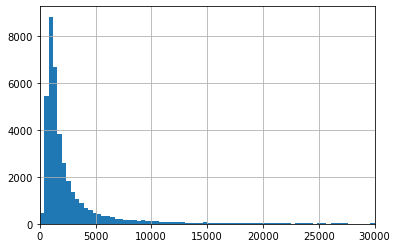

In [269]:
fig, ax = plt.subplots()
df[' shares'].hist(ax = ax, bins = 250)
ax.set_xlim(0, 30000)

In [416]:
baseline = np.array([1] * len(df[' shares'])) * df[' shares'].mean()
rmse_base = (mse(baseline, df[' shares']))**.5
base_residuals = abs(baseline - df[' shares'])
rmse_base

5990.990847429362

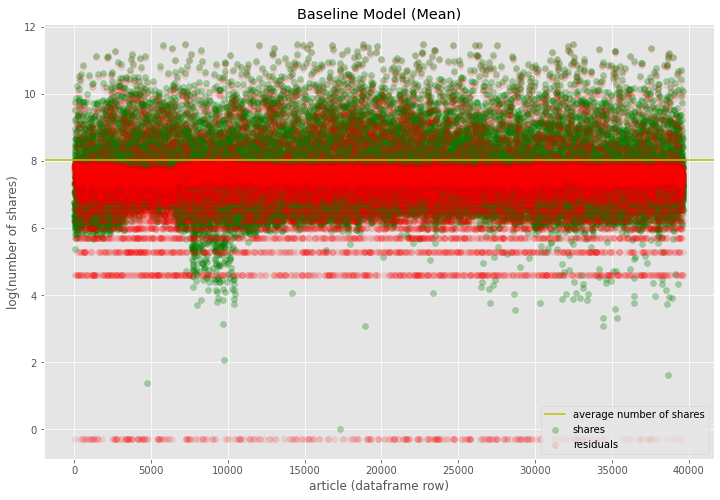

In [519]:
fig, ax = plt.subplots(figsize = (12, 8))
ax.scatter(df.index, np.log(df[' shares']), alpha = .3, c = 'g', label = 'shares')
ax.axhline(np.log(df[' shares'].mean()), label = 'average number of shares', c = 'y')
ax.set_ylabel('log(number of shares)')
ax.set_title('Baseline Model (Mean)')
ax.set_xlabel('article (dataframe row)')
ax.scatter(df.index, np.log(abs(baseline - df[' shares'])), c = 'r', alpha = .1, label = 'residuals')
#ax.axhline(np.log(np.mean(base_residuals)), label = 'average residual', c = 'black')
ax.legend()

#plt.savefig('../img/Baseline-Model.png');

### Using the mean as the baseline, want to begin with fitting a simple linear regression model 


In [271]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [272]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
X_subtrain, X_subtest, y_subtrain, y_subtest = train_test_split(X_train, y_train)

In [273]:
first = LinearRegression().fit(X_subtrain, y_subtrain)
firsthat = first.predict(X_subtest)
mse(firsthat, y_subtest) ** .5

5941.5825434187145

#### The rmse of the linear model is slightly better than the baseline. How to move forward?
- featurization
- gradient boosting regressor  / Grid Search?
- random forest regressor?


In [274]:
#lets see how random forest performs 
forest1 = RandomForestRegressor()
forest1.fit(X_subtrain, y_subtrain)
foresthat = forest1.predict(X_subtest)
mse(y_subtest, foresthat) ** .5

6131.519223227163

In [80]:
def model_test(model, X_tn, X_tst, y_tn, y_tst):
    model = model.fit(X_tn, y_tn)
    yhat = model.predict(X_tst)
    return mse(y_tst, yhat) ** .5

In [81]:
model_test(RandomForestRegressor(), X_subtrain, X_subtest, y_subtrain, y_subtest)

8187.48405777745

#### The Random Forest (out of the box) is performing as terribly as the first model, including the pattern of outliers
-should i try to gridsearch for random forest? 


In [275]:
grid = {'n_estimators':[50, 75, 100], 
       'max_depth' : [2, 4, 6],
       'max_features' : ['auto', .5]}

rf_gridsearch = GridSearchCV(estimator = RandomForestRegressor(),
                            param_grid = grid,
                            cv =5)
rf_gridsearch.fit(X_subtrain, y_subtrain)
rf_gridsearch.best_params_

{'max_depth': 4, 'max_features': 0.5, 'n_estimators': 75}

In [276]:
model_test(RandomForestRegressor(n_estimators = 75, max_depth=4, max_features=.5), X_subtrain, X_subtest, y_subtrain, y_subtest)

5937.191009222674

In [277]:
rf = RandomForestRegressor(n_estimators=75,
                          max_depth = 4,
                          max_features=.5).fit(X_train, y_train)
rf_hat = rf.predict(X_test)
rf_rmse = mse(y_test, rf_hat) ** .5
rf_rmse


5655.804957266807

#### With hyperparameters from gridsearching for random forest, got a slightly better score than with the baseline / out-of-box random forest, but it is not even better than the linear regression

In [278]:
#next, trying gradient boosting regressor 
model_test(GradientBoostingRegressor(), X_subtrain, X_subtest, y_subtrain, y_subtest)

5980.433957956011

In [435]:
#gridsearch for gradient boosting 
# gb_grid = {'learning_rate':[.1],
#           'max_depth': [1, 3, 5],
#           'min_samples_leaf' : [2, 4],
#           'max_features':[10, 30],
#           'n_estimators':[50,75, 100]}

# gb_gridsearch = GridSearchCV(estimator=GradientBoostingRegressor(),
#                             param_grid = gb_grid,
#                             cv = 10)
# gb_gridsearch.fit(X_subtrain, y_subtrain)
# gb_gridsearch.best_params_

In [436]:
model_test(GradientBoostingRegressor(learning_rate=.1, max_depth=3, max_features = .1,
                                    min_samples_leaf=3, n_estimators = 100), X_subtrain, X_subtest, y_subtrain, y_subtest)

5920.621976318736

In [437]:
gbr = GradientBoostingRegressor(learning_rate = .1,
                               max_depth = 3, 
                               max_features = .1,
                               min_samples_leaf=3, 
                               n_estimators = 100)

In [438]:
gbr.fit(X_subtrain, y_subtrain)

GradientBoostingRegressor(max_features=0.1, min_samples_leaf=3)

In [439]:
gbrhat = gbr.predict(X_subtest)
mse(y_subtest, gbrhat) ** .5

5912.942494483343

In [440]:
gbrhat2 = gbr.predict(X_train)
gbr_rmse = mse(y_train, gbrhat2) ** .5
gbr_rmse

5723.425815678582

In [442]:
gbrhat3 = gbr.predict(X_test)
final_gbr_rmse = mse(y_test, gbrhat3) ** .5
final_gbr_rmse

5643.567752363607

In [290]:
feature_importances_sorted

Index([' n_tokens_title', ' n_tokens_content', ' n_unique_tokens',
       ' n_non_stop_words', ' n_non_stop_unique_tokens', ' num_hrefs',
       ' num_self_hrefs', ' num_imgs', ' num_videos', ' average_token_length',
       ' num_keywords', ' data_channel_is_lifestyle',
       ' data_channel_is_entertainment', ' data_channel_is_bus',
       ' data_channel_is_socmed', ' data_channel_is_tech',
       ' data_channel_is_world', ' kw_min_min', ' kw_max_min', ' kw_avg_min',
       ' kw_min_max', ' kw_max_max', ' kw_avg_max', ' kw_min_avg',
       ' kw_max_avg', ' kw_avg_avg', ' self_reference_min_shares',
       ' self_reference_max_shares', ' self_reference_avg_sharess',
       ' weekday_is_monday', ' weekday_is_tuesday', ' weekday_is_wednesday',
       ' weekday_is_thursday', ' weekday_is_friday', ' weekday_is_saturday',
       ' weekday_is_sunday', ' is_weekend', ' LDA_00', ' LDA_01', ' LDA_02',
       ' LDA_03', ' LDA_04', ' global_subjectivity',
       ' global_sentiment_polarity', ' gl

In [129]:
gbr.feature_importances_

array([0.00500355, 0.05864166, 0.01121388, 0.        , 0.02802779,
       0.01576268, 0.0037401 , 0.0139307 , 0.00450316, 0.0192264 ,
       0.00032751, 0.        , 0.00252038, 0.00436037, 0.        ,
       0.        , 0.        , 0.0012558 , 0.0371049 , 0.06018928,
       0.00648537, 0.00258584, 0.01443987, 0.0447043 , 0.07197784,
       0.16493935, 0.06666917, 0.03795244, 0.05865749, 0.        ,
       0.        , 0.00099479, 0.        , 0.        , 0.        ,
       0.        , 0.00145978, 0.0305927 , 0.01975373, 0.03088235,
       0.04494775, 0.01682018, 0.00899775, 0.0020931 , 0.        ,
       0.00206839, 0.0013626 , 0.00422283, 0.00615235, 0.00064494,
       0.        , 0.02710922, 0.0119223 , 0.0209282 , 0.00828873,
       0.01285873, 0.01269204, 0.00098773])

In [153]:
feat_imp_idx = gbr.feature_importances_.argsort()
srted_idx = feat_imp_idx
srted_feats = X.columns[srted_idx]

In [520]:
srtd_feat_imps = np.sort(gbr.feature_importances_)
srtd_feat_imps

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00030373,
       0.00040864, 0.00104963, 0.00122374, 0.00160905, 0.0018857 ,
       0.0026016 , 0.00288899, 0.00358458, 0.00385184, 0.0050514 ,
       0.00532315, 0.00692202, 0.00740121, 0.00812198, 0.00813371,
       0.00818995, 0.00844271, 0.00857176, 0.00865222, 0.00892574,
       0.00922855, 0.00960307, 0.00968706, 0.01017927, 0.01103615,
       0.01138899, 0.01249979, 0.01282421, 0.01326046, 0.01360203,
       0.01381661, 0.01381977, 0.01713088, 0.01766399, 0.01814519,
       0.01942698, 0.02036908, 0.02065083, 0.02288131, 0.02288667,
       0.02645796, 0.04315677, 0.06169255, 0.0634484 , 0.07563051,
       0.084211  , 0.10236074, 0.13979779])

In [ ]:
fig, ax = plt.subplots(figsize=(8,12))
ax.barh(srted_feats[:-1], srtd_feat_imps[:-1])
ax.set_title('Feature Importances through Gradient Boosting')


Text(0.5, 1.0, 'Feature Importances through Gradient Boosting')

In [176]:
top_25 = srted_feats[::-1][:25]

In [292]:
#what happens if i refit the model with only the top 25 features according to feature importances? 
new_X = df.loc[:,top_25]
newX_train, newX_test, newy_train, newy_test = train_test_split(new_X, y)

In [182]:
rf_grid = {'n_estimators':[50, 75, 100], 
       'max_depth' : [2, 4, 6],
       'max_features' : ['auto', .5]}

new_rf_gridsearch = GridSearchCV(estimator = RandomForestRegressor(),
                            param_grid = rf_grid,
                            cv =5, verbose =1)
new_rf_gridsearch.fit(newX_train, newy_train)


Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [2, 4, 6], 'max_features': ['auto', 0.5],
                         'n_estimators': [50, 75, 100]},
             verbose=1)

In [183]:
new_rf_gridsearch.best_params_

{'max_depth': 4, 'max_features': 0.5, 'n_estimators': 75}

In [370]:
new_rf = RandomForestRegressor(n_estimators=75,
                              max_depth = 4,
                              max_features = .5).fit(newX_train, newy_train)
new_rf_hat = new_rf.predict(newX_test)
new_rf_rmse = mse(newy_test, new_rf_hat) ** .5
new_rf_rmse

5850.948855375841

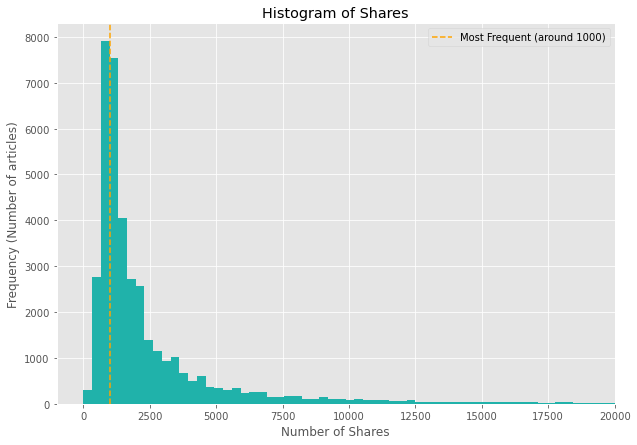

In [447]:
fig, ax = plt.subplots(figsize=(10,7))
ax.hist(df[' shares'], bins = 300, color = 'lightseagreen')
ax.axvline(1000, linestyle = '--', color = 'orange', label='Most Frequent (around 1000)')
ax.set_xlim(-1000, 20000)
ax.set_title('Histogram of Shares')
ax.set_ylabel('Frequency (Number of articles)')
ax.set_xlabel('Number of Shares')
ax.legend()
plt.savefig('../img/histogram-shares.png')